In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, BatchNormalization, CuDNNLSTM, CuDNNGRU
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [16]:
from collections import deque

In [17]:
from sklearn import preprocessing

In [18]:
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('data.dat', sep=' ')

In [20]:
df = df[df['gvkey'] == 1266]
df['year'] = df['year'].map(lambda x: str(x))
df['month'] = df['month'].map(lambda x: str(x))
df['-'] = '-'
df['timestemp'] = df['year'] + df['-'] + df['month']
df['timestemp'] = pd.to_datetime(df['timestemp'])
df = df.set_index('timestemp')
df = df.drop(['active', 'year', 'month', '-', 'date'], axis=1)
df['EBIT'] = df['saleq_ttm'] - df['cogsq_ttm'] - df['xsgaq_ttm']
df['EBIT/EV'] = df['EBIT'] / df['entval']

In [21]:
featureList = ['mom1m','mom3m','cogsq_ttm', 'xsgaq_ttm', 'oiadpq_ttm',
       'niq_ttm', 'cheq_mrq', 'rectq_mrq', 'invtq_mrq', 'acoq_mrq',
       'ppentq_mrq', 'aoq_mrq', 'dlcq_mrq', 'apq_mrq', 'txpq_mrq', 'lcoq_mrq',
       'ltq_mrq', 'seqq_mrq', 'atq_mrq', 'csho_1yr_avg', 'adjusted_price',
       'prccm', 'ajexm']

df.drop(['gvkey', 'gics-sector'], axis=1, inplace=True)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.dropna(inplace=True)

In [22]:
periods = 12

In [23]:
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns.values)

df['Y'] = df.iloc[:, -1].shift(periods=-periods)
df.dropna(inplace=True)

In [24]:
seq_df = []
prev_months = deque(maxlen=12)

for i in df.values:
    prev_months.append(i)
    if len(prev_months) == 12:
        seq_df.append(np.array(prev_months))  
        
seq_df = np.array(seq_df)

In [25]:
seq_df.shape

(411, 12, 31)

In [26]:
Y = seq_df[:, -1, -1]
X = seq_df[:, :, :-1]

In [27]:
X_train = X[:int(len(X)*0.7)]
X_test = X[int(len(X)*0.7):]

Y_train = Y[:int(len(X)*0.7)]
Y_test = Y[int(len(X)*0.7):]

In [28]:
# model = Sequential()
# model.add(CuDNNLSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
# model.add(Dropout(0.2))

# model.add(CuDNNLSTM(128))
# model.add(Dropout(0.1))

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(1, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# model.compile(
#     loss='mse',
#     optimizer=opt,
#     metrics=['mae'],
# )

# model.fit(X_train,
#           Y_train,
#           epochs=3,
#           validation_data=(X_test, Y_test))

In [62]:
model = Sequential()
model.add(LSTM(128, input_shape=X_train.shape[1:], activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu'))
model.add(Dense(1))

In [63]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=0.00001, clipnorm=1)
model.compile(loss='mse', optimizer=opt, metrics=['mse'])

model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_data=(X_test, Y_test))

Train on 287 samples, validate on 124 samples
Epoch 1/50
287/287 [==============================] - 4s 13ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 2/50
287/287 [==============================] - 1s 2ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.1988 - val_mean_squared_error: 0.1988
Epoch 3/50
287/287 [==============================] - 1s 2ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 4/50
287/287 [==============================] - 1s 2ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 5/50
287/287 [==============================] - 1s 2ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 6/50
287/287 [==============================] - 1s 2ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0334 - val_mean_squ

In [64]:
Y_pred = model.predict(X_test)

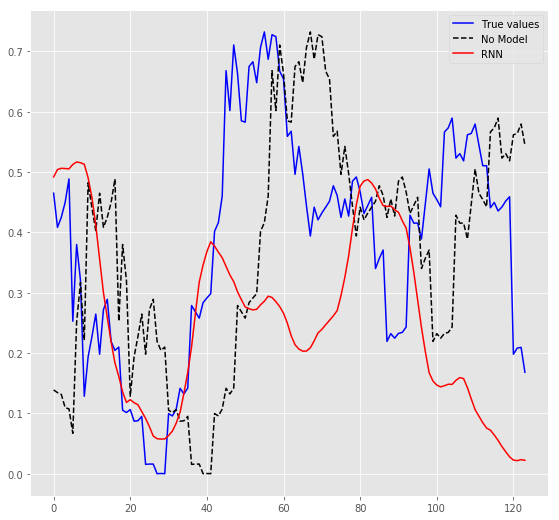

In [65]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 9))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
ax.plot(Y_test, label='True values', color='blue')
ax.plot(X_test[:, -1, -1], label='No Model', linestyle='--', color='black')
ax.plot(Y_pred, label='RNN', color='red')
ax.legend()
plt.show()

In [70]:
temp1 = np.diff(Y_test)
temp2 = np.diff(Y_pred[:, 0])
temp3 = np.diff(X_test[:, -1, -1])

[[1.         0.00762031]
 [0.00762031 1.        ]]


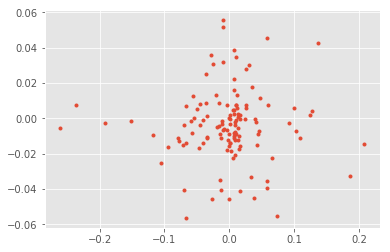

In [73]:
plt.plot(temp1, temp2, '.')
print(np.corrcoef(temp1, temp2))

[[1.        0.0340881]
 [0.0340881 1.       ]]


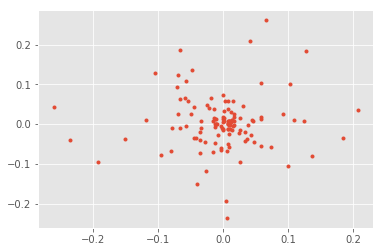

In [74]:
plt.plot(temp1, temp3, '.')
print(np.corrcoef(temp1, temp3))

In [47]:
mse(X_test[:, -1, -1], Y_test)

0.022624073813928718

In [48]:
mse(Y_pred, Y_test)

0.05674786089422437